In [ ]:
from __future__ import annotations
from dataclasses import dataclass
from rich.prompt import Prompt
from pydantic_graph import BaseNode, End, Graph, GraphRunContext

@dataclass
class MachineState:  
    user_balance: float = 0.0
    product: str | None = None


@dataclass
class InsertCoin(BaseNode[MachineState]):  
    async def run(self, ctx: GraphRunContext[MachineState]) -> CoinsInserted:  
        return CoinsInserted(float(Prompt.ask('Insert coins')))  


@dataclass
class CoinsInserted(BaseNode[MachineState]):
    amount: float  

    async def run(
        self, ctx: GraphRunContext[MachineState]
    ) -> SelectProduct | Purchase:  
        ctx.state.user_balance += self.amount  
        if ctx.state.product is not None:  
            return Purchase(ctx.state.product)
        else:
            return SelectProduct()


@dataclass
class SelectProduct(BaseNode[MachineState]):
    async def run(self, ctx: GraphRunContext[MachineState]) -> Purchase:
        return Purchase(Prompt.ask('Select product'))


PRODUCT_PRICES = {  
    'water': 1.25,
    'soda': 1.50,
    'crisps': 1.75,
    'chocolate': 2.00,
}


@dataclass
class Purchase(BaseNode[MachineState, None, None]):  
    product: str

    async def run(
        self, ctx: GraphRunContext[MachineState]
    ) -> End | InsertCoin | SelectProduct:
        if price := PRODUCT_PRICES.get(self.product):  
            ctx.state.product = self.product  
            if ctx.state.user_balance >= price:  
                ctx.state.user_balance -= price
                return End(None)
            else:
                diff = price - ctx.state.user_balance
                print(f'Not enough money for {self.product}, need {diff:0.2f} more')
                #> Not enough money for crisps, need 0.75 more
                return InsertCoin()  
        else:
            print(f'No such product: {self.product}, try again')
            return SelectProduct()  


vending_machine_graph = Graph(  
    nodes=[InsertCoin, CoinsInserted, SelectProduct, Purchase]
)


async def main():
    state = MachineState()  
    await vending_machine_graph.run(InsertCoin(), state=state)  
    print(f'purchase successful item={state.product} change={state.user_balance:0.2f}')

# 在 Jupyter 中使用 await 而不是 asyncio.run()
await main()

Insert coins:

Select product:

purchase successful item=soda change=0.50


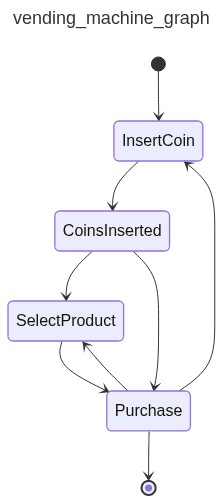

In [8]:
from IPython.display import Image, display
img_bytes = vending_machine_graph.mermaid_image(start_node=InsertCoin)
display(Image(img_bytes))

In [16]:
from openai import AsyncOpenAI
from pydantic_ai.models.openai import OpenAIChatModel
from pydantic_ai.providers.openai import OpenAIProvider
import httpx
# import asyncio
# from datetime import date
# from typing import List
# from typing_extensions import TypedDict

http_client = httpx.AsyncClient()
openai_client = AsyncOpenAI(
    api_key='sk-xxx',
    base_url='http://localhost:1234/v1',
    max_retries=3,
    http_client=http_client,
)
model = OpenAIChatModel(
    # model_name='google/gemma-3n-e4b',
    # model_name='qwen/qwen3-4b-thinking-2507',
    model_name='qwen3-0.6b-mlx',
    provider=OpenAIProvider(
        openai_client=openai_client,
    )
)

In [ ]:
# from __future__ import annotations as _annotations
from dataclasses import dataclass, field
from pydantic import BaseModel, EmailStr
from pydantic_ai import Agent, format_as_xml
from pydantic_ai.messages import ModelMessage
from pydantic_graph import (
    BaseNode, 
    # End, 
    Graph, 
    # GraphRunContext,
    )
from IPython.display import display, Markdown

@dataclass
class User:
    name: str
    email: EmailStr
    interests: list[str]


@dataclass
class Email:
    subject: str
    body: str


@dataclass
class State:
    user: User
    write_agent_messages: list[ModelMessage] = field(default_factory=list)


email_writer_agent = Agent(
    model=model,
    output_type=Email,
    system_prompt='Write a welcome email to our tech blog.',
)


@dataclass
class WriteEmail(BaseNode[State]):
    email_feedback: str | None = None

    async def run(self, ctx: GraphRunContext[State]) -> Feedback:
        if self.email_feedback:
            prompt = (
                f'Rewrite the email for the user:\n'
                f'{format_as_xml(ctx.state.user)}\n'
                f'Feedback: {self.email_feedback}'
            )
        else:
            prompt = (
                f'Write a welcome email for the user:\n'
                f'{format_as_xml(ctx.state.user)}'
            )

        result = await email_writer_agent.run(
            prompt,
            message_history=ctx.state.write_agent_messages,
        )
        ctx.state.write_agent_messages += result.new_messages()
        return Feedback(result.output)


class EmailRequiresWrite(BaseModel):
    feedback: str


class EmailOk(BaseModel):
    pass


feedback_agent = Agent[None, EmailRequiresWrite | EmailOk](
    model=model,
    output_type=EmailRequiresWrite | EmailOk,  # type: ignore
    system_prompt=(
        'Review the email and provide feedback, email must reference the users specific interests.'
        'Shutdown the assistant if the email is satisfactory.'
    ),
)


@dataclass
class Feedback(BaseNode[State, None, Email]):
    email: Email

    async def run(
        self,
        ctx: GraphRunContext[State],
    ) -> WriteEmail | End[Email]:
        prompt = format_as_xml({'user': ctx.state.user, 'email': self.email})
        result = await feedback_agent.run(prompt)
        if isinstance(result.output, EmailRequiresWrite):
            return WriteEmail(email_feedback=result.output.feedback)
        else:
            return End(self.email)


async def main():
    user = User(
        name='John Doe',
        email='john.joe@example.com',
        interests=['Haskel', 'Lisp', 'Fortran'],
    )
    state = State(user)
    feedback_graph = Graph(nodes=(WriteEmail, Feedback))
    result = await feedback_graph.run(WriteEmail(), state=state)
    # print(result.output)
    display(Markdown(f'### Final Email\n\n**Subject:** {result.output.subject}\n\n**Body:**\n\n{result.output.body}'))

    
    """
    Email(
        subject='Welcome to our tech blog!',
        body='Hello John, Welcome to our tech blog! ...',
    )
    """

await main()

### Final Email

**Subject:** Welcome to Our Tech Blog!

**Body:**

Hi John, we're excited to have you here! Our blog is dedicated to exploring programming languages like Haskel, Lisp, and Fortran. Feel free to reach out if you're interested in discussions or want to learn more. Looking forward to connecting! Best wishes, [Your Name]

# “跟AI共读PDF”状态转移图

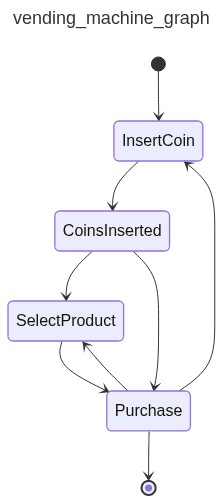

In [ ]:
# from __future__ import annotations
from dataclasses import dataclass
from rich.prompt import Prompt
from pydantic_graph import BaseNode, End, Graph, GraphRunContext
from IPython.display import Image, display

@dataclass
class PDFReadingState:  
    pdf_path: str
    current_page: int = 0
    # 记录用户的阅读进度、前情摘要
    progress: dict[int, str] = field(default_factory=dict)

# 定义一个“跟AI共读PDF”的状态转移图


@dataclass
class InsertCoin(BaseNode[MachineState]):  
    async def run(self, ctx: GraphRunContext[MachineState]) -> CoinsInserted:  
        return CoinsInserted(float(Prompt.ask('Insert coins')))  


@dataclass
class CoinsInserted(BaseNode[MachineState]):
    amount: float  

    async def run(
        self, ctx: GraphRunContext[MachineState]
    ) -> SelectProduct | Purchase:  
        ctx.state.user_balance += self.amount  
        if ctx.state.product is not None:  
            return Purchase(ctx.state.product)
        else:
            return SelectProduct()


@dataclass
class SelectProduct(BaseNode[MachineState]):
    async def run(self, ctx: GraphRunContext[MachineState]) -> Purchase:
        return Purchase(Prompt.ask('Select product'))


PRODUCT_PRICES = {  
    'water': 1.25,
    'soda': 1.50,
    'crisps': 1.75,
    'chocolate': 2.00,
}


@dataclass
class Purchase(BaseNode[MachineState, None, None]):  
    product: str

    async def run(
        self, ctx: GraphRunContext[MachineState]
    ) -> End | InsertCoin | SelectProduct:
        if price := PRODUCT_PRICES.get(self.product):  
            ctx.state.product = self.product  
            if ctx.state.user_balance >= price:  
                ctx.state.user_balance -= price
                return End(None)
            else:
                diff = price - ctx.state.user_balance
                print(f'Not enough money for {self.product}, need {diff:0.2f} more')
                #> Not enough money for crisps, need 0.75 more
                return InsertCoin()  
        else:
            print(f'No such product: {self.product}, try again')
            return SelectProduct()  


vending_machine_graph = Graph(  
    nodes=[InsertCoin, CoinsInserted, SelectProduct, Purchase]
)


img_bytes = vending_machine_graph.mermaid_image(start_node=InsertCoin)
display(Image(img_bytes))